# Document classificcation lab

* Prepare by **vomtung@gmail.com**

In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Install Required Packages

First, we need to install the necessary Python packages for our machine learning pipeline.

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Import Required Libraries

We need several libraries for this document classification task:
- **pandas**: Data manipulation and analysis
- **numpy**: Numerical computing
- **sklearn**: Machine learning tools (TF-IDF, Logistic Regression, metrics)
- **matplotlib & seaborn**: Data visualization

In [3]:
train_df = pd.read_csv('dataset/train_data.csv')
test_df = pd.read_csv('dataset/test_data.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nTraining data columns: {train_df.columns.tolist()}")
print(f"\nLabel distribution in training data:")
print(train_df['Label'].value_counts())
print(f"\nSample data:")
print(train_df.head())

Training data shape: (1230, 2)
Test data shape: (307, 2)

Training data columns: ['HTML', 'Label']

Label distribution in training data:
Label
1    645
0    585
Name: count, dtype: int64

Sample data:
                                                HTML  Label
0  Vimeo Interactive Video Experience Platform   ...      0
1  \nHacked By Shield Iran ! \nHacked By \nShield...      1
2  HACKED BY INDIAN CYBER FORCE \nYOU GOT HACKED ...      1
3  Space.com: NASA, Space Exploration and Astrono...      0
4  Home \r\nYou may be trying to access this site...      0


## Load and Explore Dataset

The dataset contains website HTML content with labels:
- **Label 0**: Normal website
- **Label 1**: Hacked/Defaced website

We have separate training and test datasets to evaluate model performance properly.

## TF-IDF Vectorization

**TF-IDF (Term Frequency-Inverse Document Frequency)** converts text into numerical features:

### Parameters:
- **max_features=10000**: Limit vocabulary to top 10,000 most important words
- **ngram_range=(1,2)**: Use both single words (unigrams) and word pairs (bigrams)
- **min_df=2**: Ignore words appearing in fewer than 2 documents
- **max_df=0.95**: Ignore words appearing in more than 95% of documents
- **stop_words='english'**: Remove common English stop words (the, and, is, etc.)

This transforms HTML content into a matrix where each row represents a document and each column represents a word/phrase with its TF-IDF weight.

In [4]:
X_train = train_df['HTML'].fillna('')
y_train = train_df['Label']

X_test = test_df['HTML'].fillna('')
y_test = test_df['Label']

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

print("Applying TF-IDF transformation...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Feature names (first 10): {tfidf_vectorizer.get_feature_names_out()[:10]}")

Training samples: 1230
Test samples: 307
Applying TF-IDF transformation...
TF-IDF matrix shape: (1230, 10000)
Feature names (first 10): ['00' '00 00' '00 pm' '000' '000 000' '000 members' '000 new' '00am'
 '00am 00pm' '00am 30pm']


## Logistic Regression Model Training

**Logistic Regression** is a linear classifier perfect for binary classification tasks like detecting hacked websites.

### Parameters:
- **C=1.0**: Regularization strength (inverse). Higher C = less regularization
- **max_iter=1000**: Maximum iterations for optimization convergence
- **random_state=42**: For reproducible results

The model learns to distinguish between normal and hacked websites based on TF-IDF features extracted from HTML content.

In [5]:
print("Training Logistic Regression model...")

logistic_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=42
)

logistic_model.fit(X_train_tfidf, y_train)

y_train_pred = logistic_model.predict(X_train_tfidf)
y_test_pred = logistic_model.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_test_proba = logistic_model.predict_proba(X_test_tfidf)[:, 1]
print(f"Model trained successfully!")

Training Logistic Regression model...
Training Accuracy: 0.9976
Test Accuracy: 0.9902
Model trained successfully!


## Model Evaluation and Analysis

### Performance Metrics:
- **Classification Report**: Precision, Recall, F1-score for each class
- **Confusion Matrix**: Visual representation of correct vs incorrect predictions
- **Feature Importance**: Top words/phrases that indicate hacked vs normal websites

### Understanding Results:
- **Precision**: Of all websites predicted as hacked, how many are actually hacked?
- **Recall**: Of all actually hacked websites, how many did we detect?
- **F1-score**: Harmonic mean of precision and recall

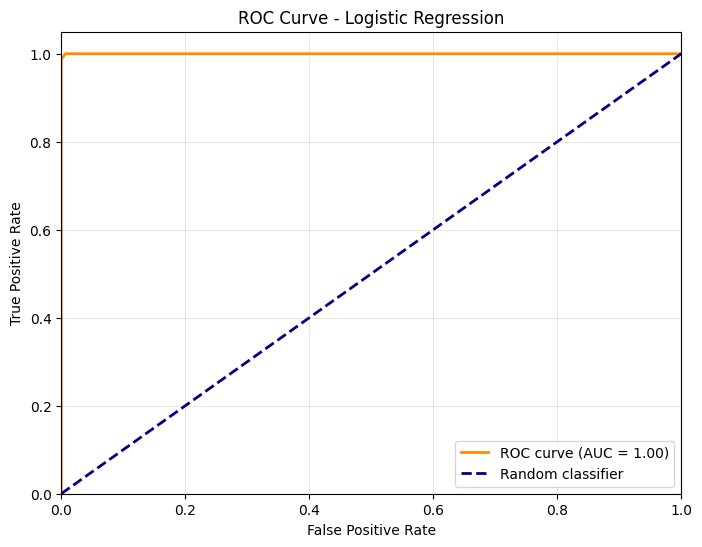

ROC AUC Score: 1.0000
Optimal threshold: 0.4537
At optimal threshold - TPR: 1.0000, FPR: 0.0068

=== THRESHOLD ANALYSIS ===
Threshold 0.300: Precision=0.947, Recall=1.000, F1=0.973, FPR=0.061, ACC=0.971
Threshold 0.500: Precision=1.000, Recall=0.981, F1=0.991, FPR=0.000, ACC=0.990
Threshold 0.700: Precision=1.000, Recall=0.894, F1=0.944, FPR=0.000, ACC=0.945
Threshold 0.454: Precision=0.994, Recall=1.000, F1=0.997, FPR=0.007, ACC=0.997


In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

# Find optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At optimal threshold - TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")

# Additional metrics at different thresholds
print("\n=== THRESHOLD ANALYSIS ===")
thresholds_to_check = [0.3, 0.5, 0.7, optimal_threshold]
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
for threshold in thresholds_to_check:
    y_pred_threshold = (y_test_proba >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    acc = accuracy_score(y_test, y_pred_threshold)
    cm = confusion_matrix(y_test, y_pred_threshold)
    # FPR = FP / (FP + TN)
    FP = cm[0,1]
    TN = cm[0,0]
    FPR_value = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    print(f"Threshold {threshold:.3f}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, FPR={FPR_value:.3f}, ACC={acc:.3f}")

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       147
      Hacked       1.00      0.98      0.99       160

    accuracy                           0.99       307
   macro avg       0.99      0.99      0.99       307
weighted avg       0.99      0.99      0.99       307



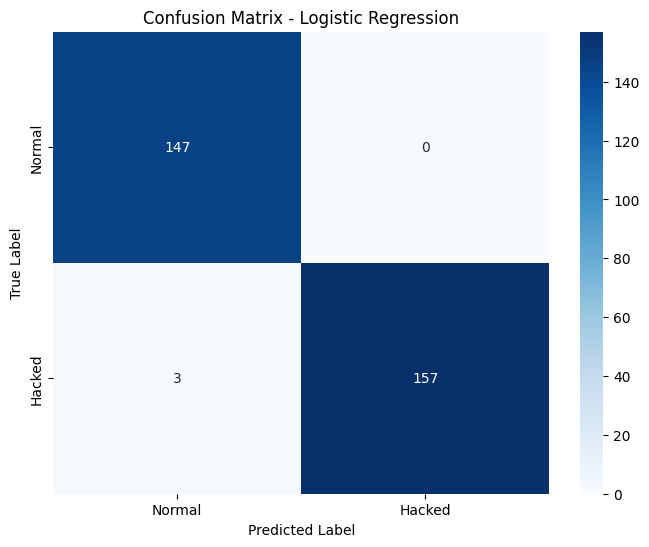


=== TOP FEATURES FOR HACKED WEBSITES ===
hacked: 7.6705
mr: 2.4660
team: 2.1029
cyber: 1.9043
greetz: 1.4082
touched: 1.3066
indonesian: 1.1870
0x1998: 1.1425
root: 1.1072
security: 1.0509

=== TOP FEATURES FOR NORMAL WEBSITES ===
2023: -1.6519
new: -1.3441
google: -1.3368
news: -1.3184
help: -1.2302
privacy: -1.1692
learn: -1.1514
sign: -1.0813
use: -1.0415
home: -1.0363


In [8]:
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Hacked']))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Hacked'],
            yticklabels=['Normal', 'Hacked'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = logistic_model.coef_[0]

top_hacked_indices = np.argsort(coefficients)[-10:]
top_hacked_features = [(feature_names[i], coefficients[i]) for i in top_hacked_indices]

top_normal_indices = np.argsort(coefficients)[:10]
top_normal_features = [(feature_names[i], coefficients[i]) for i in top_normal_indices]

print("\n=== TOP FEATURES FOR HACKED WEBSITES ===")
for feature, coef in reversed(top_hacked_features):
    print(f"{feature}: {coef:.4f}")

print("\n=== TOP FEATURES FOR NORMAL WEBSITES ===")
for feature, coef in top_normal_features:
    print(f"{feature}: {coef:.4f}")

## Testing with New Samples

This section demonstrates how to use the trained model to classify new website content.

### The `predict_website()` function:
1. **Input**: Raw HTML content as text
2. **Transform**: Apply the same TF-IDF transformation used during training
3. **Predict**: Use logistic regression to classify as Normal/Hacked
4. **Output**: Classification result with confidence percentage

We test with sample texts including both normal website content and typical hacker messages.

In [9]:
def predict_website(html_content):
    """Predict if a website is hacked or normal"""
    html_tfidf = tfidf_vectorizer.transform([html_content])
    
    prediction = logistic_model.predict(html_tfidf)[0]
    probability = logistic_model.predict_proba(html_tfidf)[0]
    
    result = "Hacked" if prediction == 1 else "Normal"
    confidence = probability[prediction] * 100
    
    return result, confidence

test_samples = [
    "Welcome to our website! We offer great products and services.",
    "HACKED BY ANONYMOUS! Your site has been compromised!",
    "Contact us for more information about our company.",
    "Hacked By Shield Iran! We Are N3TC4t - Nazila Blackhat"
]

print("=== TESTING WITH NEW SAMPLES ===")
for i, sample in enumerate(test_samples, 1):
    result, confidence = predict_website(sample)
    print(f"Sample {i}: {result} (Confidence: {confidence:.2f}%)")
    print(f"Text: {sample[:100]}...")
    print("-" * 50)

=== TESTING WITH NEW SAMPLES ===
Sample 1: Normal (Confidence: 70.52%)
Text: Welcome to our website! We offer great products and services....
--------------------------------------------------
Sample 2: Hacked (Confidence: 87.35%)
Text: HACKED BY ANONYMOUS! Your site has been compromised!...
--------------------------------------------------
Sample 3: Normal (Confidence: 66.47%)
Text: Contact us for more information about our company....
--------------------------------------------------
Sample 4: Hacked (Confidence: 85.03%)
Text: Hacked By Shield Iran! We Are N3TC4t - Nazila Blackhat...
--------------------------------------------------
